In [1]:
%matplotlib inline
import numpy as np
import glob
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import random
import os
from sklearn.preprocessing import label_binarize
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
import pickle
from scipy import stats
from scipy.stats import gaussian_kde

In [2]:
signal = pd.read_csv('process_data/signal_pred.csv',sep=',')
background = pd.read_csv('process_data/background_pred.csv',sep=',')

In [3]:
signal['signal'] = 1
background['signal'] = 0

In [4]:
analysis = pd.concat([signal, background], ignore_index=True)

In [5]:
analysis.head()

,Unnamed: 0,pt_j1,m_j1,eta_j1,phi_j1,E_j1,pt_j2,m_j2,eta_j2,phi_j2,...,deltaR2_sj23,deltaR2_sj24,deltaR2_sj34,n_subjets1,n_subjets2,event_idx,img_name,P_BG,P_SIG,signal
0,0,1210.415787,129.499352,-0.744836,-2.883347,1567.345300,1091.785816,155.362262,1.060534,0.264977,...,0.000000,0.000000,0.00000,1,1,4,4.png,0.378957,0.621043,1
1,1,1787.625573,99.168898,-0.934612,1.185407,2628.753873,1717.649940,515.054419,-1.044915,-1.955165,...,2.512072,2.512072,0.00000,1,2,8,8.png,0.027786,0.972214,1
2,2,1368.776255,104.840764,-1.136360,1.353935,2354.162865,1283.549433,452.024576,0.053019,-1.781479,...,1.015464,1.926491,2.05649,1,3,19,19.png,0.288431,0.711569,1
3,3,1659.355146,110.390275,-0.348487,2.475010,1764.594154,1634.435917,487.949083,0.102619,-0.649581,...,0.452664,0.452664,0.00000,1,2,24,24.png,0.093520,0.906480,1
4,4,1827.270115,551.510487,0.208524,-0.979991,1946.889764,1799.302155,108.942106,-0.452693,2.177153,...,0.000000,0.000000,0.00000,2,1,33,33.png,0.027147,0.972853,1


In [6]:
analysis.drop(['event_idx','img_name','Unnamed: 0', 'P_BG', 'P_SIG'], axis=1, inplace=True)

In [7]:
analysis.head()

,pt_j1,m_j1,eta_j1,phi_j1,E_j1,pt_j2,m_j2,eta_j2,phi_j2,E_j2,...,deltaR1_sj34,deltaR2_sj12,deltaR2_sj13,deltaR2_sj14,deltaR2_sj23,deltaR2_sj24,deltaR2_sj34,n_subjets1,n_subjets2,signal
0,1210.415787,129.499352,-0.744836,-2.883347,1567.345300,1091.785816,155.362262,1.060534,0.264977,1772.340209,...,0.0,1.096969,1.096969,1.096969,0.000000,0.000000,0.00000,1,1,1
1,1787.625573,99.168898,-0.934612,1.185407,2628.753873,1717.649940,515.054419,-1.044915,-1.955165,2791.763302,...,0.0,0.558392,2.013673,2.013673,2.512072,2.512072,0.00000,1,2,1
2,1368.776255,104.840764,-1.136360,1.353935,2354.162865,1283.549433,452.024576,0.053019,-1.781479,1362.520063,...,0.0,0.605989,0.517361,1.698000,1.015464,1.926491,2.05649,1,3,1
3,1659.355146,110.390275,-0.348487,2.475010,1764.594154,1634.435917,487.949083,0.102619,-0.649581,1713.973621,...,0.0,0.681621,0.778878,0.778878,0.452664,0.452664,0.00000,1,2,1
4,1827.270115,551.510487,0.208524,-0.979991,1946.889764,1799.302155,108.942106,-0.452693,2.177153,1989.823176,...,0.0,2.223210,2.223210,2.223210,0.000000,0.000000,0.00000,2,1,1


In [8]:
X = analysis.drop(['signal'], axis=1)
y = analysis['signal']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)

In [9]:
bdt_SAMME_R = pickle.load(open('bdt_SAMME_R_BL3.sav', 'rb'))

In [10]:
from sklearn.metrics import roc_curve, auc, accuracy_score
from scipy.spatial import distance

def optim_thres(fpr, tpr, threshold):
    TOP = np.array([0,1])
    xy = np.array(list(zip(fpr, tpr)))
    dist = [(i, distance.euclidean(TOP, v)) for i,v in enumerate(xy)]
    dist.sort(key = lambda x: x[1], reverse=False)
    i, d = dist[0]
    return (fpr[i], tpr[i], threshold[i])


def compare_train_test(clf, X_train, y_train, X_test, y_test, bins=50):
    decisions = []
    for X,y in ((X_train, y_train), (X_test, y_test)):
        d1 = clf.decision_function(X[y>0.5]).ravel()
        d2 = clf.decision_function(X[y<0.5]).ravel()
        decisions += [d1, d2]
        
    low = min(np.min(d) for d in decisions)
    high = max(np.max(d) for d in decisions)
    low_high = (low,high)

    fig, ax = plt.subplots(1,2,figsize=(12,6))
    ax[0].hist(decisions[0],
             color='r', alpha=0.5, range=low_high, bins=bins,
             histtype='stepfilled', density=True,
             label='signal (train)')
    ax[0].hist(decisions[1],
             color='b', alpha=0.5, range=low_high, bins=bins,
             histtype='stepfilled', density=True,
             label='background (train)')
    hist, bins = np.histogram(decisions[2],
                              bins=bins, range=low_high, density=True)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    width = (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    ax[0].errorbar(center, hist, yerr=err, fmt='o', c='r', label='signal (test)')

    hist, bins = np.histogram(decisions[3],
                              bins=bins, range=low_high, density=True)

    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    ax[0].errorbar(center, hist, yerr=err, fmt='o', c='b', label='background (test)')

    # get the KS score
    ks = stats.ks_2samp(decisions[0], decisions[2])
    ax[0].plot([], [], ' ', label='KS Statistic (p-value) :'+str(round(ks[0],2))+'('+str(round(ks[1],2))+')')
    ax[0].set_xlabel("BDT scores")
    ax[0].set_ylabel("Arbitrary units")
    ax[0].legend(loc='best')
    
    ######ROC
    probas_ = clf.fit(X_train, y_train).decision_function(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, probas_)
    roc_auc = auc(fpr, tpr)    
    ax[1].plot(1-fpr, tpr, lw=2.2, alpha=0.7, c='r',
             label='ROC (AUC = %0.2f)' % (roc_auc))
 #   ax[1].plot([0, 1], [0, 1], linestyle='--', lw=2, color='k',
 #        label='Chance', alpha=.8)
    ax[1].set_xlim([-0.05, 1.05])
    ax[1].set_ylim([-0.05, 1.05])
    ax[1].set_xlabel('background rejection')
    ax[1].set_ylabel('efficiency')
#    ax[1].set_title('Receiver operating characteristic')
    xp, yp, thr = optim_thres(fpr, tpr, thresholds)
    label = "threshold: " + str(round(thr, 4))
    ax[1].plot(1-xp, yp, 'b*',label=label)
    plt.legend(loc="best")

In [ ]:
#compare_train_test(bdt_SAMME_R,X_train,y_train,X_test,y_test)

thr = 0.0004

In [12]:
blackbox = pd.read_csv('../notebooks/TablularDataUpdatedCode/combined_BlackBox.csv', sep=',')

In [13]:
blackbox.shape

(1000000, 31)

In [14]:
blackbox.keys()

Index(['pt_j1', 'm_j1', 'eta_j1', 'phi_j1', 'E_j1', 'pt_j2', 'm_j2', 'eta_j2',
       'phi_j2', 'E_j2', 'deltaeta', 'deltaphi', 'mEratio1', 'mEratio2',
       'm_jj', 'pt_asym', 'deltaR1_sj12', 'deltaR1_sj13', 'deltaR1_sj14',
       'deltaR1_sj23', 'deltaR1_sj24', 'deltaR1_sj34', 'deltaR2_sj12',
       'deltaR2_sj13', 'deltaR2_sj14', 'deltaR2_sj23', 'deltaR2_sj24',
       'deltaR2_sj34', 'n_subjets1', 'n_subjets2', 'event_idx'],
      dtype='object')

In [15]:
blackbox.drop(['event_idx'], axis=1, inplace=True)

In [16]:
decisions_bb = bdt_SAMME_R.decision_function(blackbox)

In [17]:
decisions_bb.shape

(1000000,)

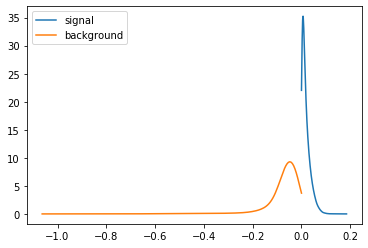

In [18]:
density_sig = gaussian_kde(decisions_bb[decisions_bb > 0.0004])
density_bg = gaussian_kde(decisions_bb[decisions_bb < 0.0004])
xs_sig = np.linspace(min(decisions_bb[decisions_bb > 0.0004]),
                     max(decisions_bb[decisions_bb > 0.0004]),200)
xs_bg = np.linspace(min(decisions_bb[decisions_bb < 0.0004]),
                    max(decisions_bb[decisions_bb < 0.0004]), 200)

density_sig.covariance_factor = lambda : .25
density_sig._compute_covariance()
density_bg.covariance_factor = lambda : .25
density_bg._compute_covariance()
plt.plot(xs_sig,density_sig(xs_sig),label='signal')
plt.plot(xs_bg,density_bg(xs_bg),label='background')
plt.legend()
plt.show()

In [19]:
pValue = stats.ks_2samp(density_bg(xs_bg),density_sig(xs_sig))

In [20]:
pValue

Ks_2sampResult(statistic=0.265, pvalue=1.3921047931216453e-06)

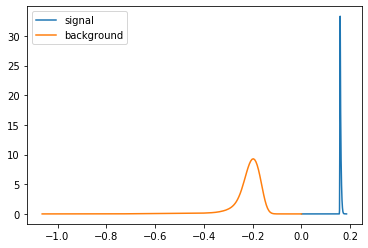

In [21]:
xs_sig2 = np.linspace(min(decisions_bb),
                     max(decisions_bb),200)
xs_bg2 = np.linspace(min(decisions_bb),
                    max(decisions_bb), 200)


density_sig.covariance_factor = lambda : .25
density_sig._compute_covariance()
density_bg.covariance_factor = lambda : .25
density_bg._compute_covariance()
plt.plot(xs_sig,density_sig(xs_sig2),label='signal')
plt.plot(xs_bg,density_bg(xs_bg2),label='background')
plt.legend()
plt.show()

In [22]:
stats.ks_2samp(density_bg(xs_bg2),density_sig(xs_sig2))

Ks_2sampResult(statistic=0.82, pvalue=4.862054680600275e-68)

## Export the selected threshold data

In [23]:
len(decisions_bb[decisions_bb >  0.004])

74002

In [40]:
threshold =  0.04

- The index in the decisions_bb and blackbox dataframe are the same, so I can mask the blackobox dataframe with these indexes and export the data we want.

In [41]:
#select the indexes we want for an given threshold:
select_signal_idx = np.where(decisions_bb > threshold)[0]
select_bg_idx = np.where(decisions_bb < threshold)[0]

In [42]:
# using the indexes to mask the dataframe:
df_sig_selceted = blackbox.loc[select_signal_idx]
df_bg_selected = blackbox.loc[select_bg_idx]

In [43]:
df_sig_selceted.head()

,pt_j1,m_j1,eta_j1,phi_j1,E_j1,pt_j2,m_j2,eta_j2,phi_j2,E_j2,...,deltaR1_sj24,deltaR1_sj34,deltaR2_sj12,deltaR2_sj13,deltaR2_sj14,deltaR2_sj23,deltaR2_sj24,deltaR2_sj34,n_subjets1,n_subjets2
27,1216.433026,100.003465,-1.504489,-1.482843,2874.944395,1132.969431,427.706063,0.111019,1.709174,1217.554137,...,0.000000,0.000000,0.700278,1.662113,1.662113,1.849827,1.849827,0.000000,1,2
107,1739.202989,757.497827,-0.149996,1.960233,1914.992777,1629.069683,114.233867,0.221336,-0.778164,1673.041149,...,2.266470,1.493558,0.808903,0.808903,0.808903,0.000000,0.000000,0.000000,3,1
118,1747.166558,833.079166,0.583840,-0.714365,2216.051168,1648.365615,91.381197,-0.296268,2.462043,1723.662931,...,1.078515,1.590320,2.480379,2.480379,2.480379,0.000000,0.000000,0.000000,3,1
353,2063.986392,98.952852,0.210895,-0.651952,2112.375286,1920.342634,713.817163,0.299638,2.552161,2130.345663,...,0.000000,0.000000,0.687343,0.919157,2.621951,0.664365,2.416701,3.078749,1,3
541,1712.878448,99.441972,0.114130,-0.186302,1726.911751,1658.703047,490.329490,-0.434227,2.990057,1882.530164,...,0.000000,0.000000,0.569843,2.970624,2.970624,3.107691,3.107691,0.000000,1,2


In [44]:
df_bg_selected.head()

,pt_j1,m_j1,eta_j1,phi_j1,E_j1,pt_j2,m_j2,eta_j2,phi_j2,E_j2,...,deltaR1_sj24,deltaR1_sj34,deltaR2_sj12,deltaR2_sj13,deltaR2_sj14,deltaR2_sj23,deltaR2_sj24,deltaR2_sj34,n_subjets1,n_subjets2
0,1566.501884,78.078517,0.910635,0.998456,2263.508385,1474.595018,52.681697,-0.845254,-2.115717,2034.161438,...,0.000000,0.0,2.278551,2.278551,2.278551,0.000000,0.000000,0.0,1,1
1,1577.694337,556.425085,-0.341437,2.038277,1760.784193,1507.667391,139.651810,0.355842,-1.182940,1610.199591,...,1.437564,0.0,0.465766,1.248572,1.248572,0.928294,0.928294,0.0,2,2
2,1203.892154,310.425437,0.016417,-0.119756,1243.427091,1120.565432,81.372586,-1.365276,3.047636,2338.979432,...,0.000000,0.0,3.343752,3.343752,3.343752,0.000000,0.000000,0.0,1,1
3,1341.208547,76.466927,-0.518972,-0.940237,1527.828884,1262.902184,131.437785,-0.570886,2.177688,1480.196234,...,0.000000,0.0,2.252883,2.252883,2.252883,0.000000,0.000000,0.0,1,1
4,1511.157066,142.948981,0.079453,2.021742,1522.654315,1052.734327,54.471954,-0.039693,-1.645257,1054.970977,...,0.000000,0.0,1.644629,1.644629,1.644629,0.000000,0.000000,0.0,1,1


In [45]:
#check the lenght and if the shapes match with the original dataframe:
df_bg_selected.shape, df_sig_selceted.shape

((989707, 30), (10293, 30))

In [46]:
df_bg_selected.shape[0] + df_sig_selceted.shape[0] == blackbox.shape[0]

True

In [47]:
# export the selected data to csv:
df_sig_selceted.to_csv('../selected data csv BL1/signal/selected_signal_thr_0d04.csv', sep=',')
df_bg_selected.to_csv('../selected data csv BL1/background/selected_background_thr_0d04.csv', sep=',')

In [ ]:
blackbox[(blackbox['m_j1'] > 50.) & (blackbox['m_j1'] < 150.)].m_j1.describe()

In [ ]:
df_sig_selceted[(df_sig_selceted['m_j1'] > 50.) & (df_sig_selceted['m_j1'] < 150.)].m_j1.describe()

In [ ]:
len(df_sig_selceted[(df_sig_selceted['m_j1'] > 50.) & (df_sig_selceted['m_j1'] < 150.)])